Target: Lighter Model <br>

Results: <br>
Parameters: 14,506 (Almost ~4 times reduction in parameters) <br> <br>
Best Training Accuracy: 99.41 <br>
Best Test Accuracy: 98.78 <br>

Analysis: <br>
Good model <br>
Can still be pushed further for accuracy, no over-fitting  <br>

In [1]:
!pip install torchsummary

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) #input -28 Output- 26 RF 3
        self.conv2 = nn.Conv2d(16, 32, 1, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 16, 1, padding=0)
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.AdaptiveAvgPool2d(7)
        self.conv5 = nn.Conv2d(32, 16, 3)
        self.conv6 = nn.Conv2d(16, 10, 5)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [6]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 28, 28]             544
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]             528
            Conv2d-5           [-1, 32, 14, 14]           4,640
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 16, 5, 5]           4,624
            Conv2d-8             [-1, 10, 1, 1]           4,010
Total params: 14,506
Trainable params: 14,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.06
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [7]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy.append(100*correct/len(train_loader.dataset))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

             
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100*correct/len(test_loader.dataset)) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nEpoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch:  1


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.6414708495140076 batch_id=468 Accuracy = 53.11: 100%|█████████████████████████| 469/469 [00:14<00:00, 32.22it/s]



Train set: Average loss: 1.3188, Accuracy: 31866/60000 (53.11%)

Test set: Average loss: 0.5410, Accuracy: 7952/10000 (79.52%)


Epoch:  2


loss=0.18851052224636078 batch_id=468 Accuracy = 87.15: 100%|████████████████████████| 469/469 [00:14<00:00, 32.35it/s]



Train set: Average loss: 0.3345, Accuracy: 52289/60000 (87.15%)

Test set: Average loss: 0.2866, Accuracy: 8876/10000 (88.76%)


Epoch:  3


loss=0.14226360619068146 batch_id=468 Accuracy = 93.10: 100%|████████████████████████| 469/469 [00:15<00:00, 30.87it/s]



Train set: Average loss: 0.1819, Accuracy: 55861/60000 (93.10%)

Test set: Average loss: 0.0657, Accuracy: 9806/10000 (98.06%)


Epoch:  4


loss=0.0036586225032806396 batch_id=468 Accuracy = 98.26: 100%|██████████████████████| 469/469 [00:14<00:00, 31.28it/s]



Train set: Average loss: 0.0561, Accuracy: 58954/60000 (98.26%)

Test set: Average loss: 0.0601, Accuracy: 9804/10000 (98.04%)


Epoch:  5


loss=0.025349467992782593 batch_id=468 Accuracy = 98.54: 100%|███████████████████████| 469/469 [00:14<00:00, 32.80it/s]



Train set: Average loss: 0.0466, Accuracy: 59123/60000 (98.54%)

Test set: Average loss: 0.0516, Accuracy: 9832/10000 (98.32%)


Epoch:  6


loss=0.05592906102538109 batch_id=468 Accuracy = 98.70: 100%|████████████████████████| 469/469 [00:17<00:00, 26.77it/s]



Train set: Average loss: 0.0403, Accuracy: 59221/60000 (98.70%)

Test set: Average loss: 0.0459, Accuracy: 9861/10000 (98.61%)


Epoch:  7


loss=0.02690327726304531 batch_id=468 Accuracy = 98.92: 100%|████████████████████████| 469/469 [00:18<00:00, 25.01it/s]



Train set: Average loss: 0.0335, Accuracy: 59354/60000 (98.92%)

Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)


Epoch:  8


loss=0.022000133991241455 batch_id=468 Accuracy = 98.92: 100%|███████████████████████| 469/469 [00:16<00:00, 27.85it/s]



Train set: Average loss: 0.0323, Accuracy: 59352/60000 (98.92%)

Test set: Average loss: 0.0425, Accuracy: 9865/10000 (98.65%)


Epoch:  9


loss=0.003757864236831665 batch_id=468 Accuracy = 99.10: 100%|███████████████████████| 469/469 [00:18<00:00, 25.63it/s]



Train set: Average loss: 0.0280, Accuracy: 59461/60000 (99.10%)

Test set: Average loss: 0.0363, Accuracy: 9891/10000 (98.91%)


Epoch:  10


loss=0.03970746695995331 batch_id=468 Accuracy = 99.16: 100%|████████████████████████| 469/469 [00:15<00:00, 29.71it/s]



Train set: Average loss: 0.0259, Accuracy: 59497/60000 (99.16%)

Test set: Average loss: 0.0354, Accuracy: 9883/10000 (98.83%)


Epoch:  11


loss=0.0027073025703430176 batch_id=468 Accuracy = 99.26: 100%|██████████████████████| 469/469 [00:16<00:00, 29.13it/s]



Train set: Average loss: 0.0235, Accuracy: 59557/60000 (99.26%)

Test set: Average loss: 0.0396, Accuracy: 9876/10000 (98.76%)


Epoch:  12


loss=0.003580540418624878 batch_id=468 Accuracy = 99.24: 100%|███████████████████████| 469/469 [00:16<00:00, 27.83it/s]



Train set: Average loss: 0.0225, Accuracy: 59542/60000 (99.24%)

Test set: Average loss: 0.0404, Accuracy: 9874/10000 (98.74%)


Epoch:  13


loss=0.030040642246603966 batch_id=468 Accuracy = 99.35: 100%|███████████████████████| 469/469 [00:17<00:00, 26.58it/s]



Train set: Average loss: 0.0201, Accuracy: 59610/60000 (99.35%)

Test set: Average loss: 0.0452, Accuracy: 9872/10000 (98.72%)


Epoch:  14


loss=0.0060432651080191135 batch_id=468 Accuracy = 99.41: 100%|██████████████████████| 469/469 [00:17<00:00, 26.36it/s]



Train set: Average loss: 0.0199, Accuracy: 59643/60000 (99.41%)

Test set: Average loss: 0.0378, Accuracy: 9877/10000 (98.77%)


Epoch:  15


loss=0.003958255052566528 batch_id=468 Accuracy = 99.41: 100%|███████████████████████| 469/469 [00:17<00:00, 26.29it/s]



Train set: Average loss: 0.0172, Accuracy: 59643/60000 (99.41%)

Test set: Average loss: 0.0402, Accuracy: 9878/10000 (98.78%)



Text(0.5, 1.0, 'Test_Accuracy')

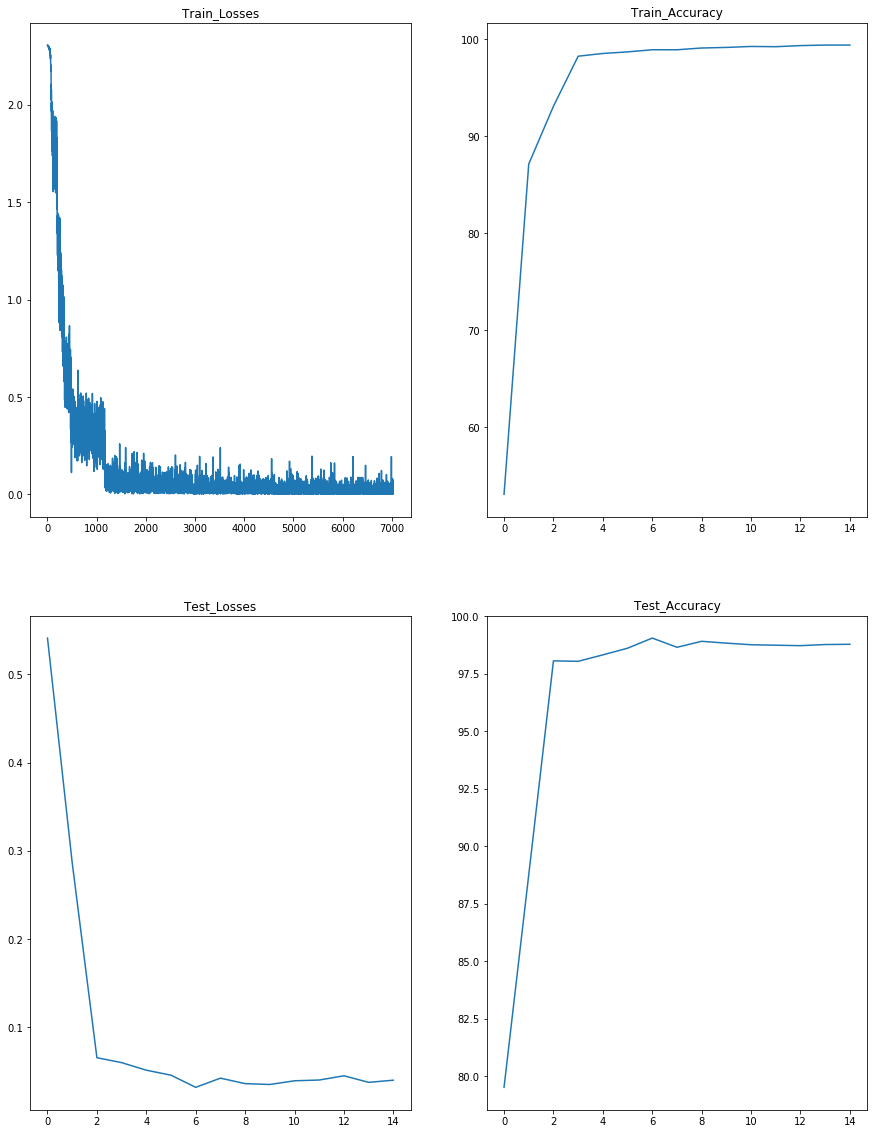

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(15,20))
ax[0,0].plot(train_losses)
ax[0,0].set_title('Train_Losses')
ax[0,1].plot(train_accuracy)
ax[0,1].set_title('Train_Accuracy')

ax[1,0].plot(test_losses)
ax[1,0].set_title('Test_Losses')
ax[1,1].plot(test_accuracy)
ax[1,1].set_title('Test_Accuracy')